In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# will disable "future warnings"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# install the libraries – see: http://biom-format.org/
!pip install numpy
!pip install biom-format
!pip install h5py
! pip install fbprophet

     |████████████████████████████████| 11.8MB 195kB/s 
  Created wheel for biom-format: filename=biom_format-2.1.7-cp36-cp36m-linux_x86_64.whl size=12093580 sha256=be868de0436e70cd1fa20eb2b7b3567bc2f33650f7566caddcfb341b3dd36d1d
  Stored in directory: /root/.cache/pip/wheels/1a/62/a8/b8881b0d3da81d55d38e4c3ca9f9375b061be2543cc221c56b
Successfully built biom-format


In [0]:
# import the library and load the biom file
import biom
data = biom.load_table("/content/gdrive/My Drive/67_otu_table.biom")

In [0]:
meta = pd.read_csv("/content/gdrive/My Drive/550_prep_72_qiime_20161216-085930.txt",sep='\t',header=0)
meta = meta.set_index("#SampleID")
meta.index.names = ['SampleID']

In [6]:
# have a look at the meta data per sample
for i,s in enumerate(meta.iloc[0,:]):
  print(meta.columns[i],'\t',s)

BarcodeSequence 	 ATACTCACTCAG
LinkerPrimerSequence 	 GTGTGCCAGCMGCCGCGGTAA
center_name 	 CCME
center_project_name 	 Moving pictures of the human microbiome
experiment_design_description 	 Sample collection and DNA isolation were performed as described in Costello et al. [6]; and PCR, sequencing, and quality filtering of reads were performed as described in Caporaso et al. [14]. Samples were not collected on days 422 through 437.  To facilitate massively parallel sequencing (1967 samples), barcodes were reused across six lanes in a single Illumina GAIIx, with 374, 372, 364, 271, 265, and 323 samples in lanes one through six, respectively (differing from Caporaso et al. [14], where samples were pooled and run over seven lanes). Sixteen samples were ultimately excluded from the analysis as fourteen samples were identified as potentially mislabeled (discussed below), and the barcodes for two samples were not found in the sequencing output, likely indicating a problem with amplification fo

In [0]:
# convert the biom data to a data-frame and rename the index field 
# this might takes some minutes for larger files
D = data.to_dataframe()
D = D.transpose()
D.index.names = ['SampleID']

In [0]:
# reduce meta data to essential information
M = meta[["common_sample_site","host_subject_id","collection_timestamp"]]

In [9]:
# print("%d different time stamps."%(len(set(M["collection_timestamp"]))))
# print("%d different hours in those time stamps."%(len(set([s.split(" ")[1] for s in M["collection_timestamp"]]))))
# can remove them
M.loc[:,"collection_timestamp"] = [s.split(" ")[0] for s in M["collection_timestamp"]]
# to check, if body_site == common_sample_site
# M[[M.iloc[i,0].split(":")[1] != M.iloc[i,1] for i in range(len(M.index))]]
# its not. common_sample_site has the right name.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**visualization**

In [250]:
# possible body sites
print("sample sites:", set(M["common_sample_site"]))
site = "R_palm"

sample sites: {'feces', 'R_palm', 'Tongue', 'L_palm'}


In [251]:
# choosing a person
print(list(set(M["host_subject_id"])))
person = "M3"
person

['M3', 'F4']


'M3'

In [0]:
#selection of subset
selection = (M["host_subject_id"] == person) & (M["common_sample_site"] == site)

In [336]:
# choose some interesting species
x = list((D[selection] > 2.0).sum(axis=0).sort_values(ascending=False).index)
species0 = x[5]
species1 = x[50]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [345]:
D0 = D[selection][species0]
D1 = D[selection][species1]
DD = dict({species0: D0, species1: D1})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [0]:
# dates
dates = list(M[selection]["collection_timestamp"])

***FB prophet***


**species 0**

In [0]:
savepath="/content/gdrive/My Drive/week06/"

In [0]:
def analysis(spec, trim=0):
  X = pd.DataFrame([dates,DD[spec]]).transpose()
  X.columns = (["ds","y"])

  if trim > 0:
    # remove all values of y above 1000
    X = X[X["y"] <= trim]

  m = Prophet()
  m.fit(X)

  future = m.make_future_dataframe(periods=31)
  forecast = m.predict(future)

# --- plot data with uncertainty and forecast --- #
  fig = m.plot(forecast)
  plt.savefig(savepath+"plot_map_additive_%s_%d.pdf"%(spec,trim),format='pdf')
# --- components (MAP, additive) --- #
  fig = m.plot_components(forecast)
  plt.savefig(savepath+"seasonalities_map_additive_%s_%d.pdf"%(spec,trim),format='pdf')
# --- MCMC to better estimate uncertainty estimation --- #
  m = Prophet(mcmc_samples=300)
  m.fit(X)

  future = m.make_future_dataframe(periods=0)

  forecast = m.predict(future)
  fig = m.plot(forecast)
  plt.savefig(savepath+"plot_mcmc_additive_%s_%d.pdf"%(spec,trim),format='pdf')
# --- components (MCMC, additive) --- #
  fig = m.plot_components(forecast)
  plt.savefig(savepath+"seasonalities_mcmc_additive_%s_%d.pdf"%(spec,trim),format='pdf')
# --- changepoints (MCMC, additive) --- #
  fig = m.plot(forecast)
  a = add_changepoints_to_plot(fig.gca(), m, forecast)
  plt.savefig(savepath+"changepoints_mcmc_additive_%s_%d.pdf"%(spec,trim),format='pdf')
# --- MULTIPLICATIVE FORECAST --- #
# --- plot (MCMC, multiplicative)
  m = Prophet(seasonality_mode='multiplicative',mcmc_samples=300)
  m.fit(X)
  forecast = m.predict(future)
  fig = m.plot(forecast)
  plt.savefig(savepath+"changepoints_mcmc_multiplicative_%s_%d.pdf"%(spec,trim),format='pdf')
# --- components (MCMC, multiplicative) --- #
  fig = m.plot_components(forecast)
  plt.savefig(savepath+"seasonalities_mcmc_multiplicative_%s_%d.pdf"%(spec,trim),format='pdf')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


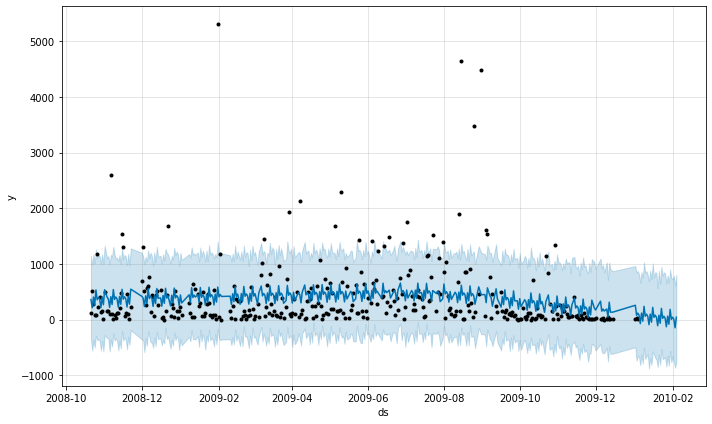

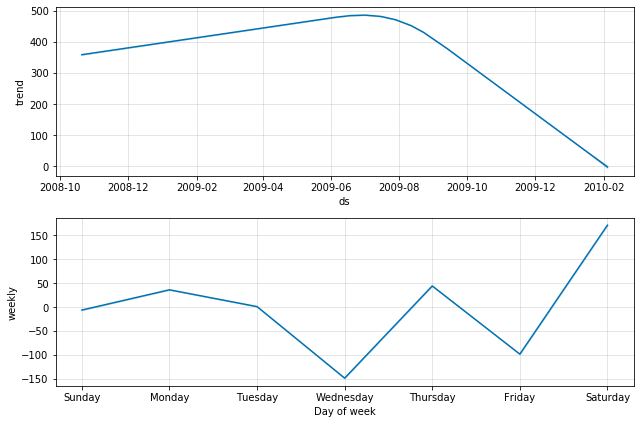

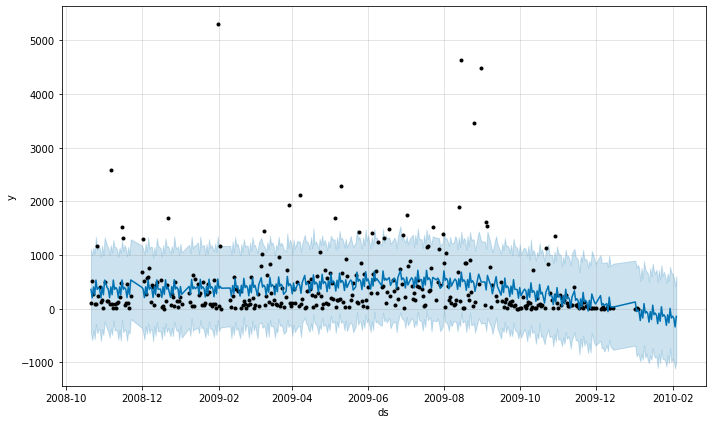

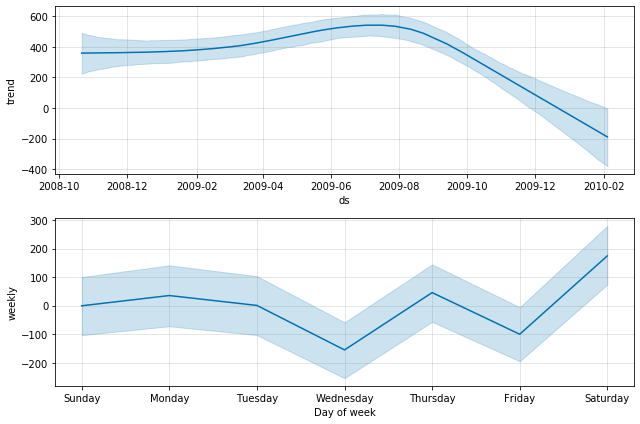

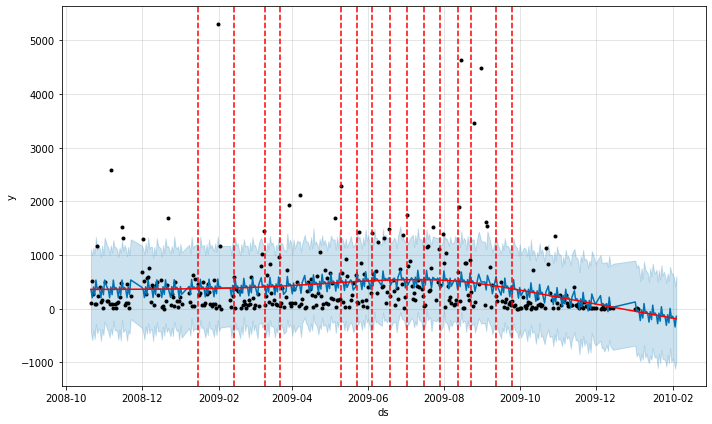

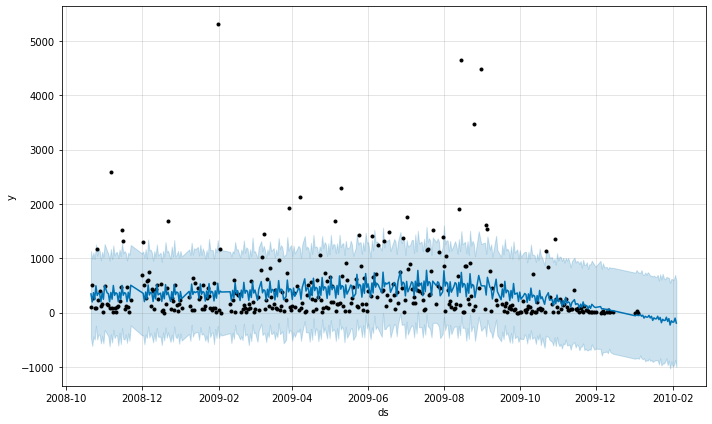

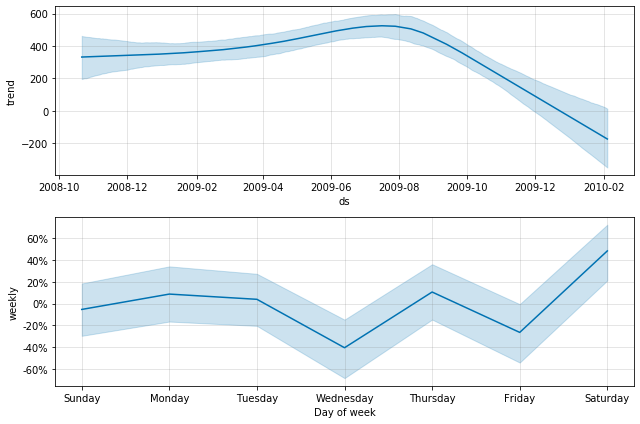

In [351]:
analysis(species0)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


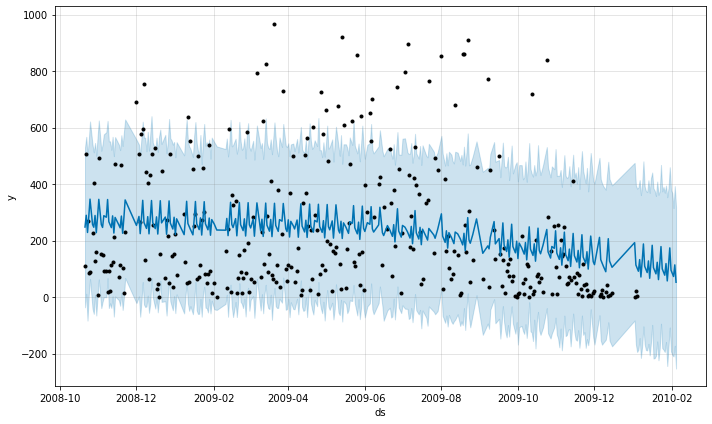

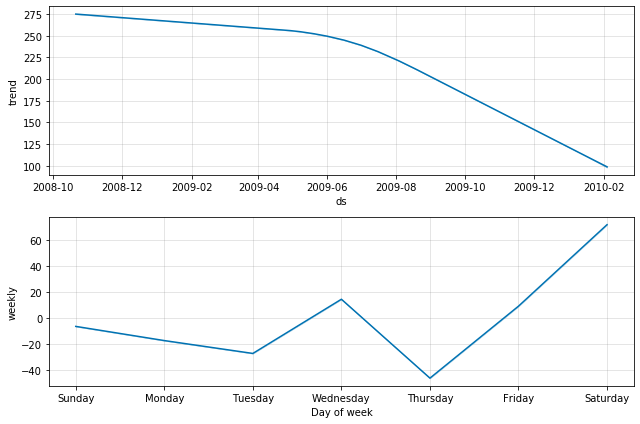

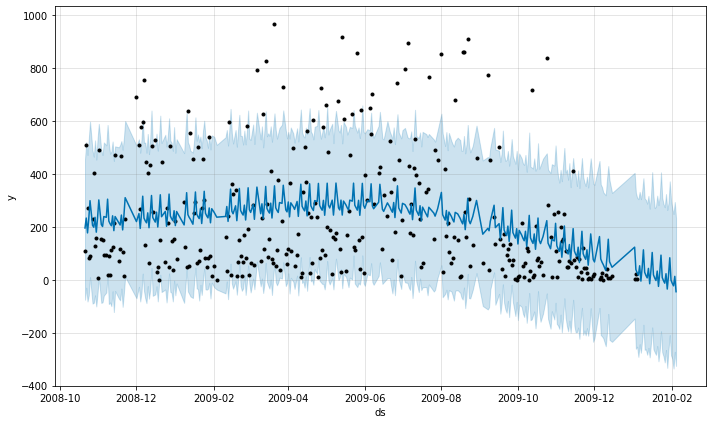

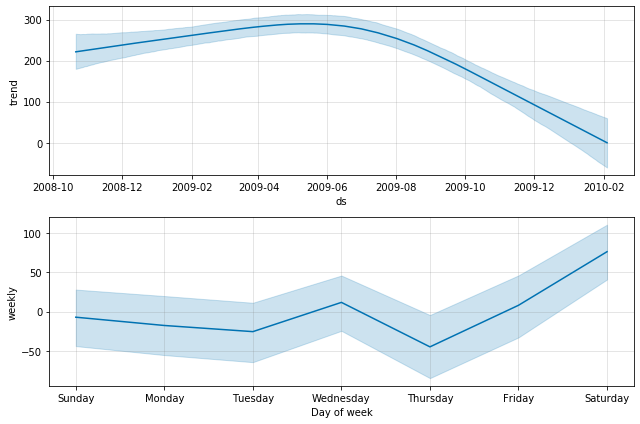

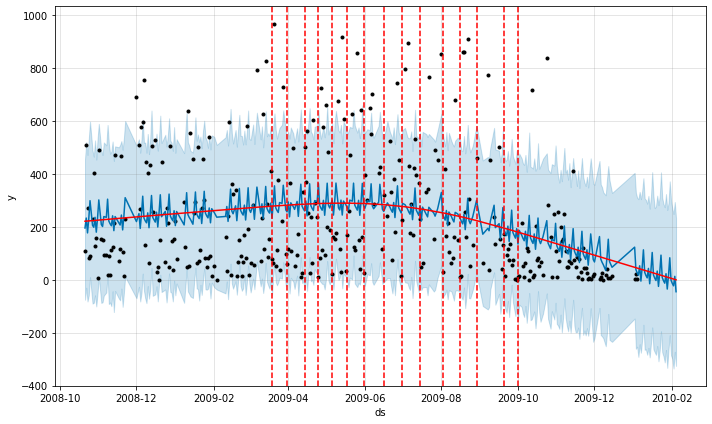

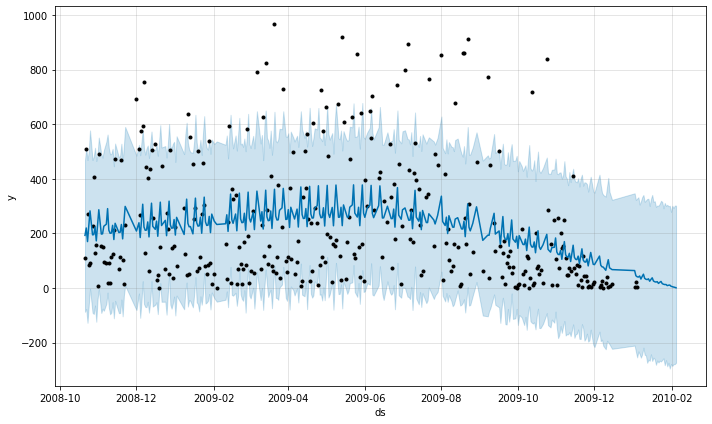

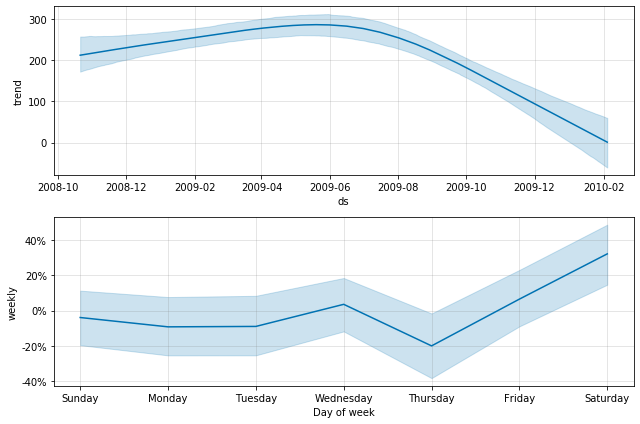

In [352]:
analysis(species0,1000)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


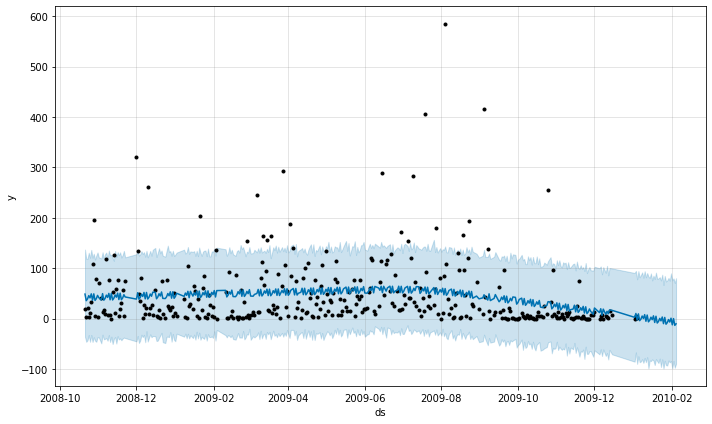

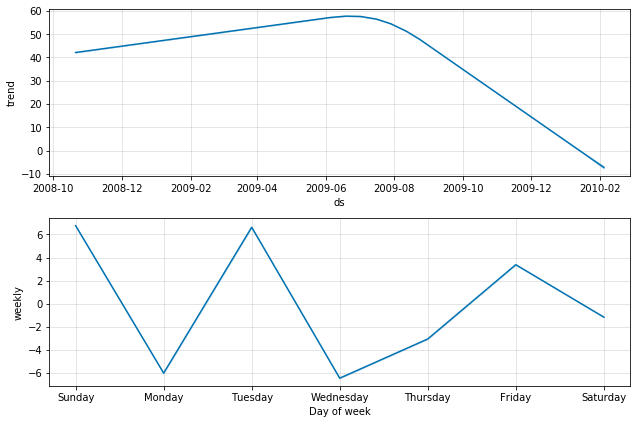

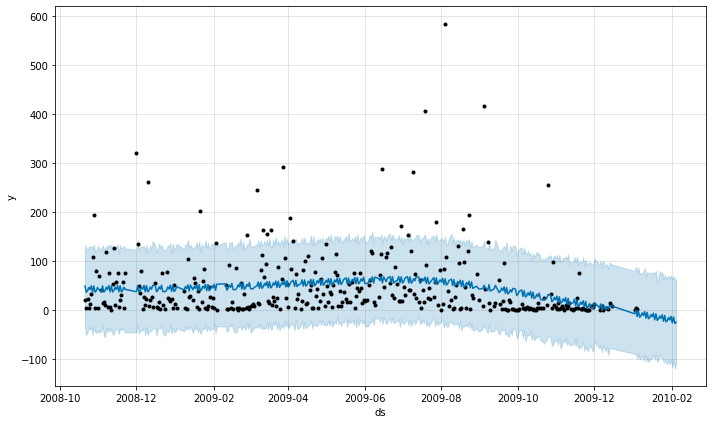

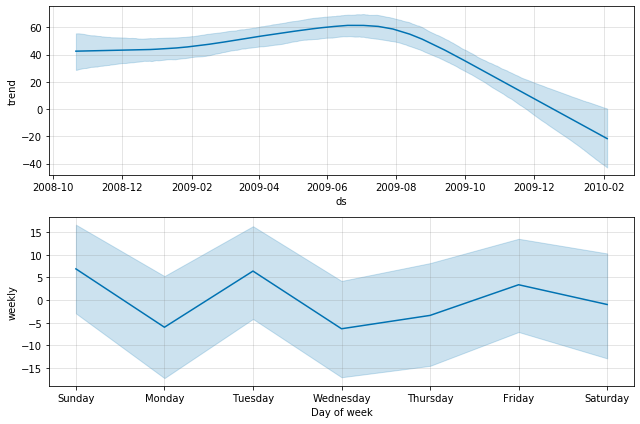

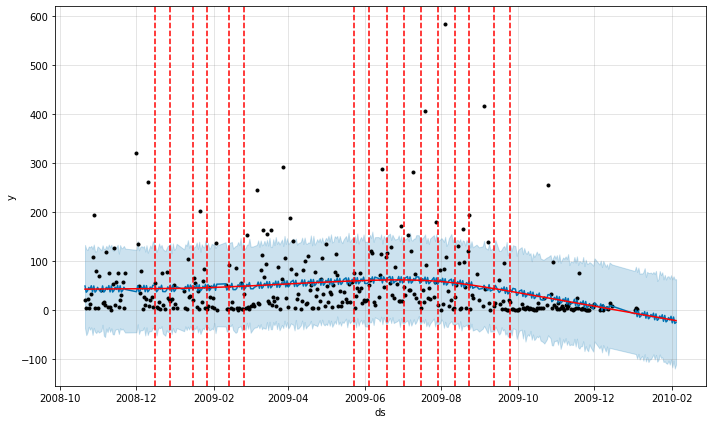

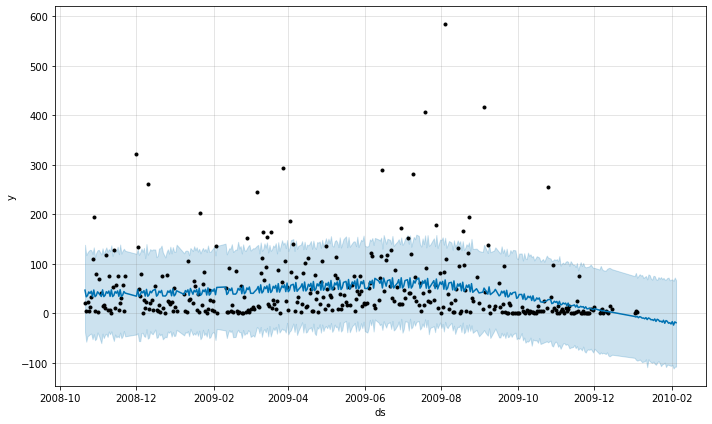

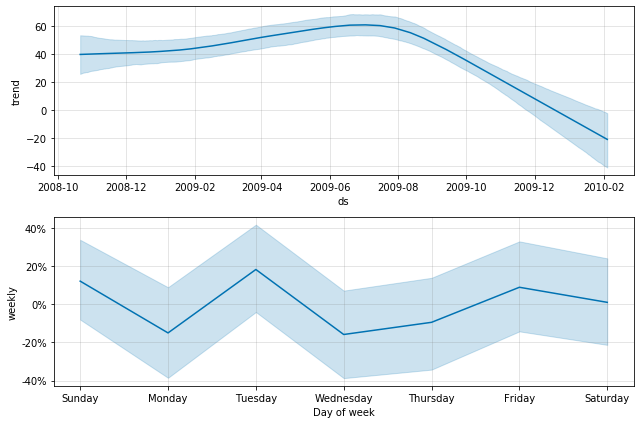

In [357]:
analysis(species1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


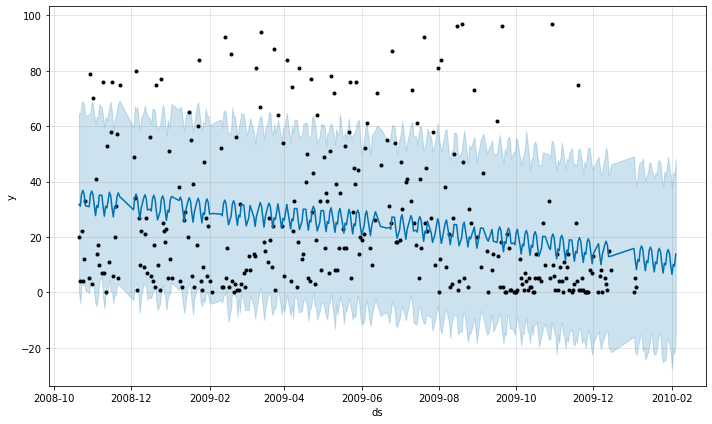

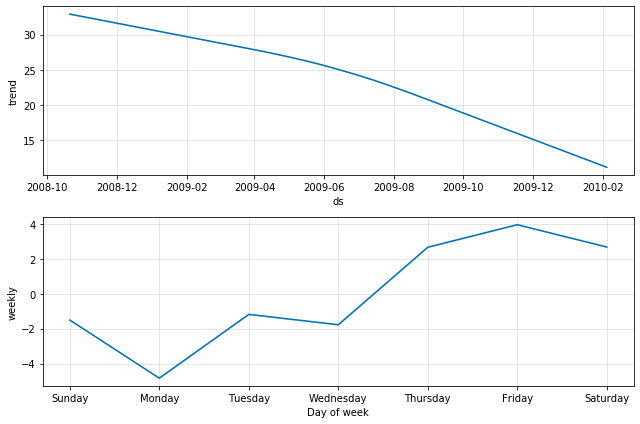

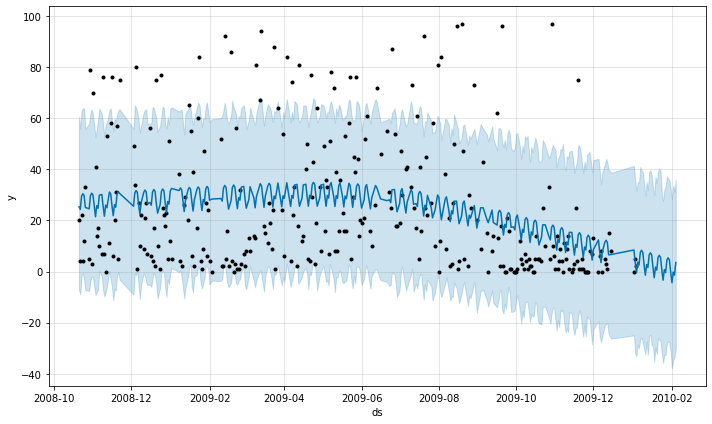

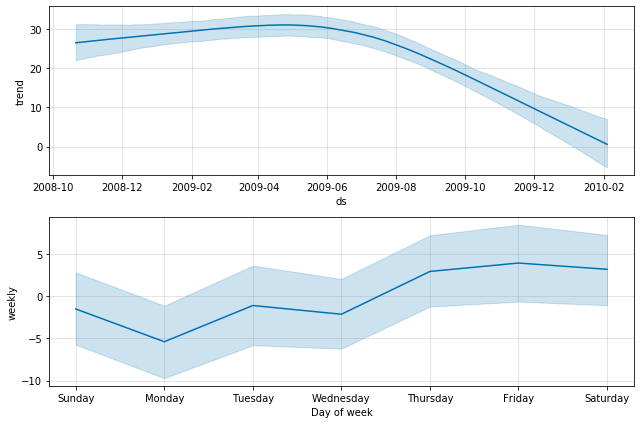

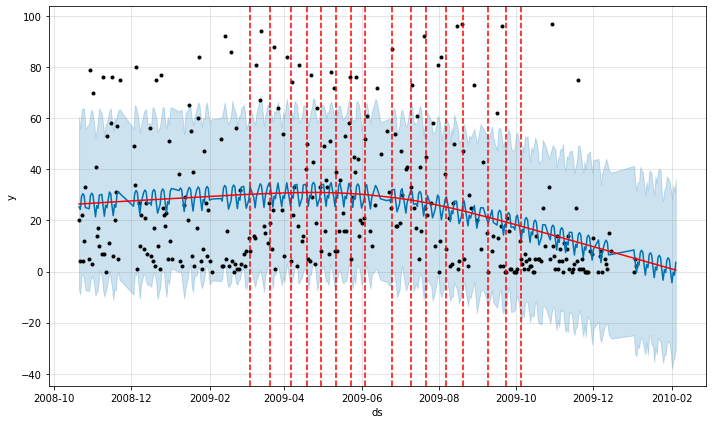

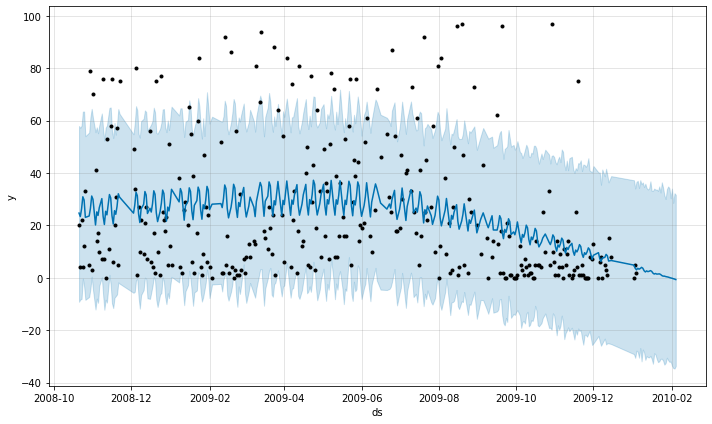

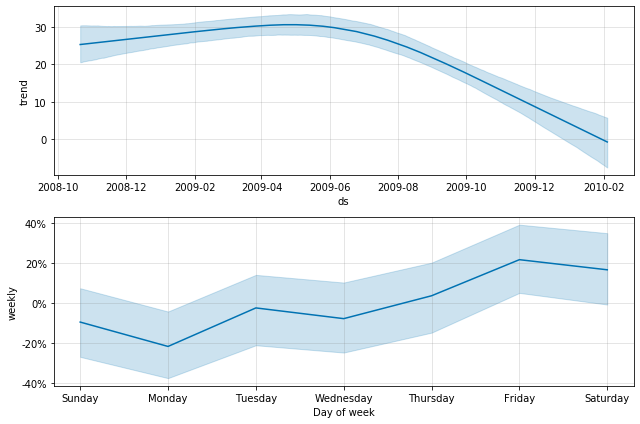

In [358]:
analysis(species1,100)